<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

## 02. Modelling 

<br/><br/>

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## Libraries Import  

<br/><br/>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=1)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [72]:
pd.set_option('display.max_rows',10)
pd.set_option('display.max_columns', None)

In [4]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

In [5]:
# run to avoid warnings
import warnings
warnings.filterwarnings('ignore')

## Modelling  

<br/><br/>

In [6]:
# retrieve information about variable types
continuous_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                   '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                   'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'TotalSFAbvGrd', 'TotalSF',
                   'LotOpenArea', 'FloorAreaRatio', 'TotalBath', 'SalePrice']

discrete_vars = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'Age']

ordinal_vars = ['OverallQual', 'OverallCond', 'CentralAir', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'LandSlope',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'PavedDrive', 'Fence']

nominal_vars = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
                'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature',
                'SaleType', 'SaleCondition']

In [7]:
# define quantitative and categorical variables
quant_vars = continuous_vars + discrete_vars
categ_vars = ordinal_vars + nominal_vars
price = ['SalePrice']

## *A. Using fixed characteristics*

In [8]:
# load the data
df_f = pd.read_csv('datasets/house_02_fixed.csv')

In [9]:
# drop collinear fixed features
collinear_f = ['LotOpenArea', 'TotalSFAbvGrd', 'GarageCars', 'GrLivArea', 'GarageYrBlt', 'TotRmsAbvGrd',
               'TotalBsmtSF', 'BedroomAbvGr', '1stFlrSF', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath',
               'FullBath', 'HalfBath', 'GarageType', 'MiscFeature', 'YearBuilt', 'MSSubClass']

df_f.drop(collinear_f, axis = 1, inplace = True)

In [10]:
# dummify categorical variables
df_f_dum = pd.get_dummies(df_f, columns=[x for x in df_f.columns if x in nominal_vars], drop_first=True)

In [11]:
df_f_dum.head()

,LotFrontage,LotArea,LandSlope,YearRemodAdd,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,TotalSF,FloorAreaRatio,TotalBath,Age,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_None,Condition2_Norm,Condition2_PosA,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450.0,3,2003.0,1,706,0,150,1,0,548,0,61,0,0,0,0,0,2,2008,208500,2566.0,0.202367,3.5,5,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,80.0,9600.0,3,1976.0,4,978,0,284,1,1,460,298,0,0,0,0,0,0,5,2007,181500,2524.0,0.131458,2.5,31,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,68.0,11250.0,3,2002.0,2,486,0,434,1,1,608,0,42,0,0,0,0,0,9,2008,223500,2706.0,0.158756,3.5,7,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,60.0,9550.0,3,1970.0,1,216,0,540,1,1,642,0,35,272,0,0,0,0,2,2006,140000,2473.0,0.179791,2.0,91,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,84.0,14260.0,3,2000.0,3,655,0,490,1,1,836,192,84,0,0,0,0,0,12,2008,250000,3343.0,0.154137,3.5,8,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [12]:
# check the proportion of houses per year sold
df_f['YrSold'].value_counts(normalize = True)

2009    0.231327
2007    0.225526
2006    0.215373
2008    0.208122
2010    0.119652
Name: YrSold, dtype: float64

In [13]:
# create a train-test split based on YrSold (pre-2010 is train, 2010 is test)
X_train = df_f_dum[df_f_dum['YrSold'] < 2010].copy()
X_test = df_f_dum[df_f_dum['YrSold'] == 2010].copy()

y_train = X_train.pop('SalePrice')
y_test = X_test.pop('SalePrice')

In [14]:
# check the shape of the modelling sets
print('Training set shape')
print('X:', X_train.shape)
print('y:', y_train.shape)
print('')
print('Test set shape')
print('X:', X_test.shape)
print('y:', y_test.shape)

Training set shape
X: (1214, 109)
y: (1214,)

Test set shape
X: (165, 109)
y: (165,)


In [15]:
# select quantitative features which still are in the dataframe
quant_cols = [x for x in X_train.columns if x in quant_vars]

# rescale the numerical values in train and test sets
scaler = StandardScaler()
X_train[quant_cols] = scaler.fit_transform(X_train[quant_cols])
X_test[quant_cols] = scaler.transform(X_test[quant_cols])

### Linear Regression (without regularisation)

In [16]:
# instantiate the model
linreg = LinearRegression()

# fit the model
linreg.fit(X_train, y_train)

# calculate the scores
a_linreg_train = linreg.score(X_train, y_train)
a_linreg_test = linreg.score(X_test, y_test)
a_linreg_cv = (cross_val_score(linreg, X_train, y_train, cv = 10)).mean()

a_linreg_predictions_train = linreg.predict(X_train)
a_linreg_predictions = linreg.predict(X_test)

a_linreg_MSE = metrics.mean_squared_error(y_test, a_linreg_predictions)
a_linreg_MAE = metrics.mean_absolute_error(y_test, a_linreg_predictions)

# residual_train = y_train - predicted_train
# residual_2 = y_test - predicted

# collect the scores in a dataframe to compare different models later
a_linreg_df = pd.DataFrame([a_linreg_train, a_linreg_test, a_linreg_cv, a_linreg_MSE, a_linreg_MAE],
                           index = ['train', 'test', 'CV', 'MSE', 'MAE'], columns=['A. Linear Reg'])

# score the model
print('A. Linear Regression Scores: \n')
print('R-squared train score: ', a_linreg_train)
print('R-squared test score:  ', a_linreg_test)
print('R-squared CV score:    ', a_linreg_cv)
print('Mean Squared Error:    ', a_linreg_MSE)
print('Mean Absolute Error:   ', a_linreg_MAE)

A. Linear Regression Scores: 

R-squared train score:  0.8539640327237201
R-squared test score:   -7.383839824914759e+23
R-squared CV score:     -1.1764011468796027e+19
Mean Squared Error:     2.56391459795738e+33
Mean Absolute Error:    3941938146570805.5


In [17]:
# display the model intercept
print('Intercept:', linreg.intercept_)

Intercept: 147153.38292833607


In [18]:
# collect the model coefficients in a dataframe
linreg_coef = pd.DataFrame(list(zip(X_train.columns, linreg.coef_)), columns = ['variable','coefficient'])
linreg_coef['coef_abs'] = abs(linreg_coef['coefficient'])

# display the largest model coefficients
linreg_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

,variable,coefficient,coef_abs
72,Condition2_RRAe,-6.504198e+17,6.504198e+17
90,RoofStyle_Shed,6.504198e+17,6.504198e+17
71,Condition2_PosA,1.140477e+05,1.140477e+05
62,Condition1_Norm,8.517977e+04,8.517977e+04
97,SaleType_Con,7.814886e+04,7.814886e+04
69,Condition2_None,-6.915946e+04,6.915946e+04
20,TotalSF,3.677555e+04,3.677555e+04
43,Neighborhood_Edwards,-3.091414e+04,3.091414e+04
96,SaleType_CWD,3.041298e+04,3.041298e+04
52,Neighborhood_NridgHt,3.037074e+04,3.037074e+04


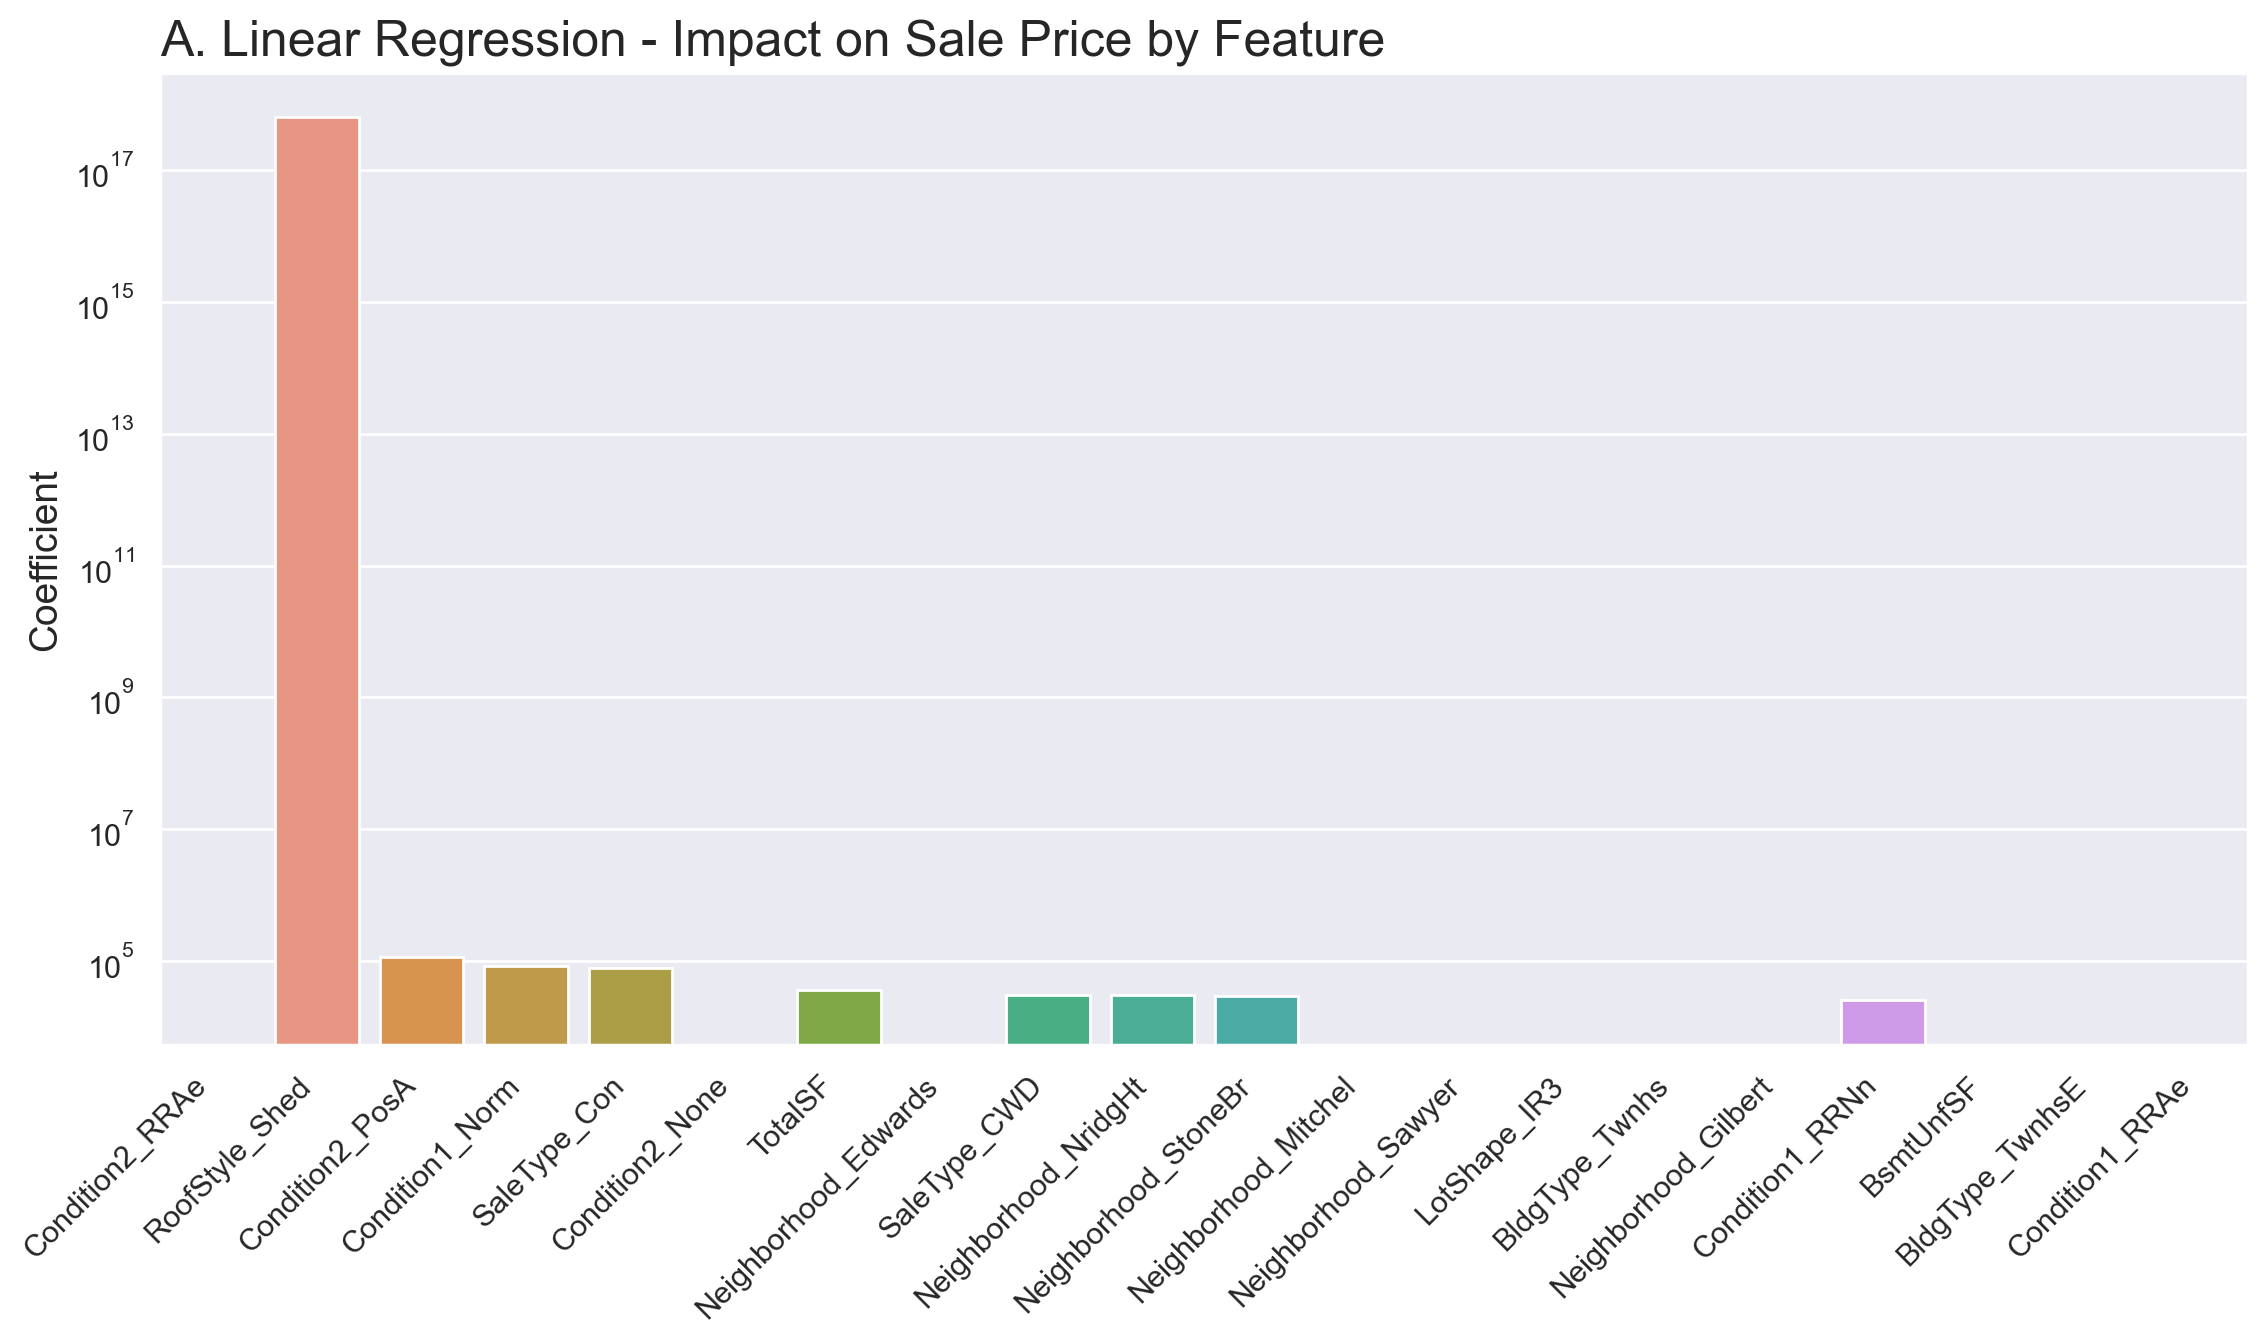

In [76]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=linreg_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', log=True, ax=ax)
ax.set_title('A. Linear Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Lasso Regression with LassoCV

In [27]:
# instantiate a LassoCV model
opt_lasso = LassoCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_lasso.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_lasso.alpha_)

Optimal Alpha: 114.89510001873097


In [28]:
# instantiate the model
lasso = Lasso(alpha=opt_lasso.alpha_)

# fit the model
lasso.fit(X_train, y_train)

# calculate the scores
a_lasso_train = lasso.score(X_train, y_train)
a_lasso_test = lasso.score(X_test, y_test)
a_lasso_cv = (cross_val_score(lasso, X_train, y_train, cv = 10)).mean()

a_lasso_predictions_train = lasso.predict(X_train)
a_lasso_predictions = lasso.predict(X_test)

a_lasso_MSE = metrics.mean_squared_error(y_test, a_lasso_predictions)
a_lasso_MAE = metrics.mean_absolute_error(y_test, a_lasso_predictions)

# collect the scores in a dataframe to compare different models later
a_lasso_df = pd.DataFrame([a_lasso_train, a_lasso_test, a_lasso_cv, a_lasso_MSE, a_lasso_MAE],
                           index = ['train', 'test', 'CV', 'MSE', 'MAE'], columns=['A. Lasso Reg'])

# score the model
print('A. Lasso Regression Scores: \n')
print('R-squared train score: ', a_lasso_train)
print('R-squared test score:  ', a_lasso_test)
print('R-squared CV score:    ', a_lasso_cv)
print('Mean Squared Error:    ', a_lasso_MSE)
print('Mean Absolute Error:   ', a_lasso_MAE)

A. Lasso Regression Scores: 

R-squared train score:  0.8352903420309533
R-squared test score:   0.8598230575394129
R-squared CV score:     0.7637929795488867
Mean Squared Error:     486740933.70637274
Mean Absolute Error:    16220.468178359593


In [29]:
# display the model intercept
print('Intercept:', lasso.intercept_)

Intercept: 154056.59838796538


In [30]:
# collect the model coefficients in a dataframe
lasso_coef = pd.DataFrame(list(zip(X_train.columns, lasso.coef_)), columns = ['variable','coefficient'])
lasso_coef['coef_abs'] = abs(lasso_coef['coefficient'])

# display the largest model coefficients
lasso_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

,variable,coefficient,coef_abs
52,Neighborhood_NridgHt,34346.325650,34346.325650
20,TotalSF,31160.678091,31160.678091
51,Neighborhood_NoRidge,28988.072213,28988.072213
58,Neighborhood_StoneBr,26288.938924,26288.938924
42,Neighborhood_Crawfor,22959.349760,22959.349760
57,Neighborhood_Somerst,22325.624187,22325.624187
43,Neighborhood_Edwards,-15545.801538,15545.801538
5,BsmtFinSF1,-14989.847861,14989.847861
7,BsmtUnfSF,-14397.968180,14397.968180
77,BldgType_Twnhs,-12480.419233,12480.419233


In [35]:
# display the coefficients which has been reduced to 0
lasso_zeroed = lasso_coef[lasso_coef['coefficient'] == 0].shape[0]
print('Lasso Regression has zeroed',lasso_zeroed , 'coefficients.')
list(lasso_coef['variable'][lasso_coef['coefficient'] == 0].values)

Lasso Regression has zeroed 49 coefficients.


['LandSlope',
 'MiscVal',
 'MSZoning_RH',
 'LotShape_IR2',
 'LandContour_Low',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_ClearCr',
 'Neighborhood_IDOTRR',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_SWISU',
 'Neighborhood_SawyerW',
 'Condition1_PosA',
 'Condition1_PosN',
 'Condition1_RRAe',
 'Condition1_RRAn',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Condition2_None',
 'Condition2_Norm',
 'Condition2_PosA',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'BldgType_2fmCon',
 'HouseStyle_1.5Unf',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'RoofStyle_Gambrel',
 'RoofStyle_Hip',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'Foundation_Slab',
 'Foundation_Stone',
 'Foundation_Wood',
 'SaleType_CWD',
 'SaleType_Con',
 'SaleType_ConLD',
 'SaleType_ConLI',
 'SaleType_ConLw',
 'SaleType_Oth',
 'SaleType_WD',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'SaleCondition_Family',
 'SaleCondition_Par

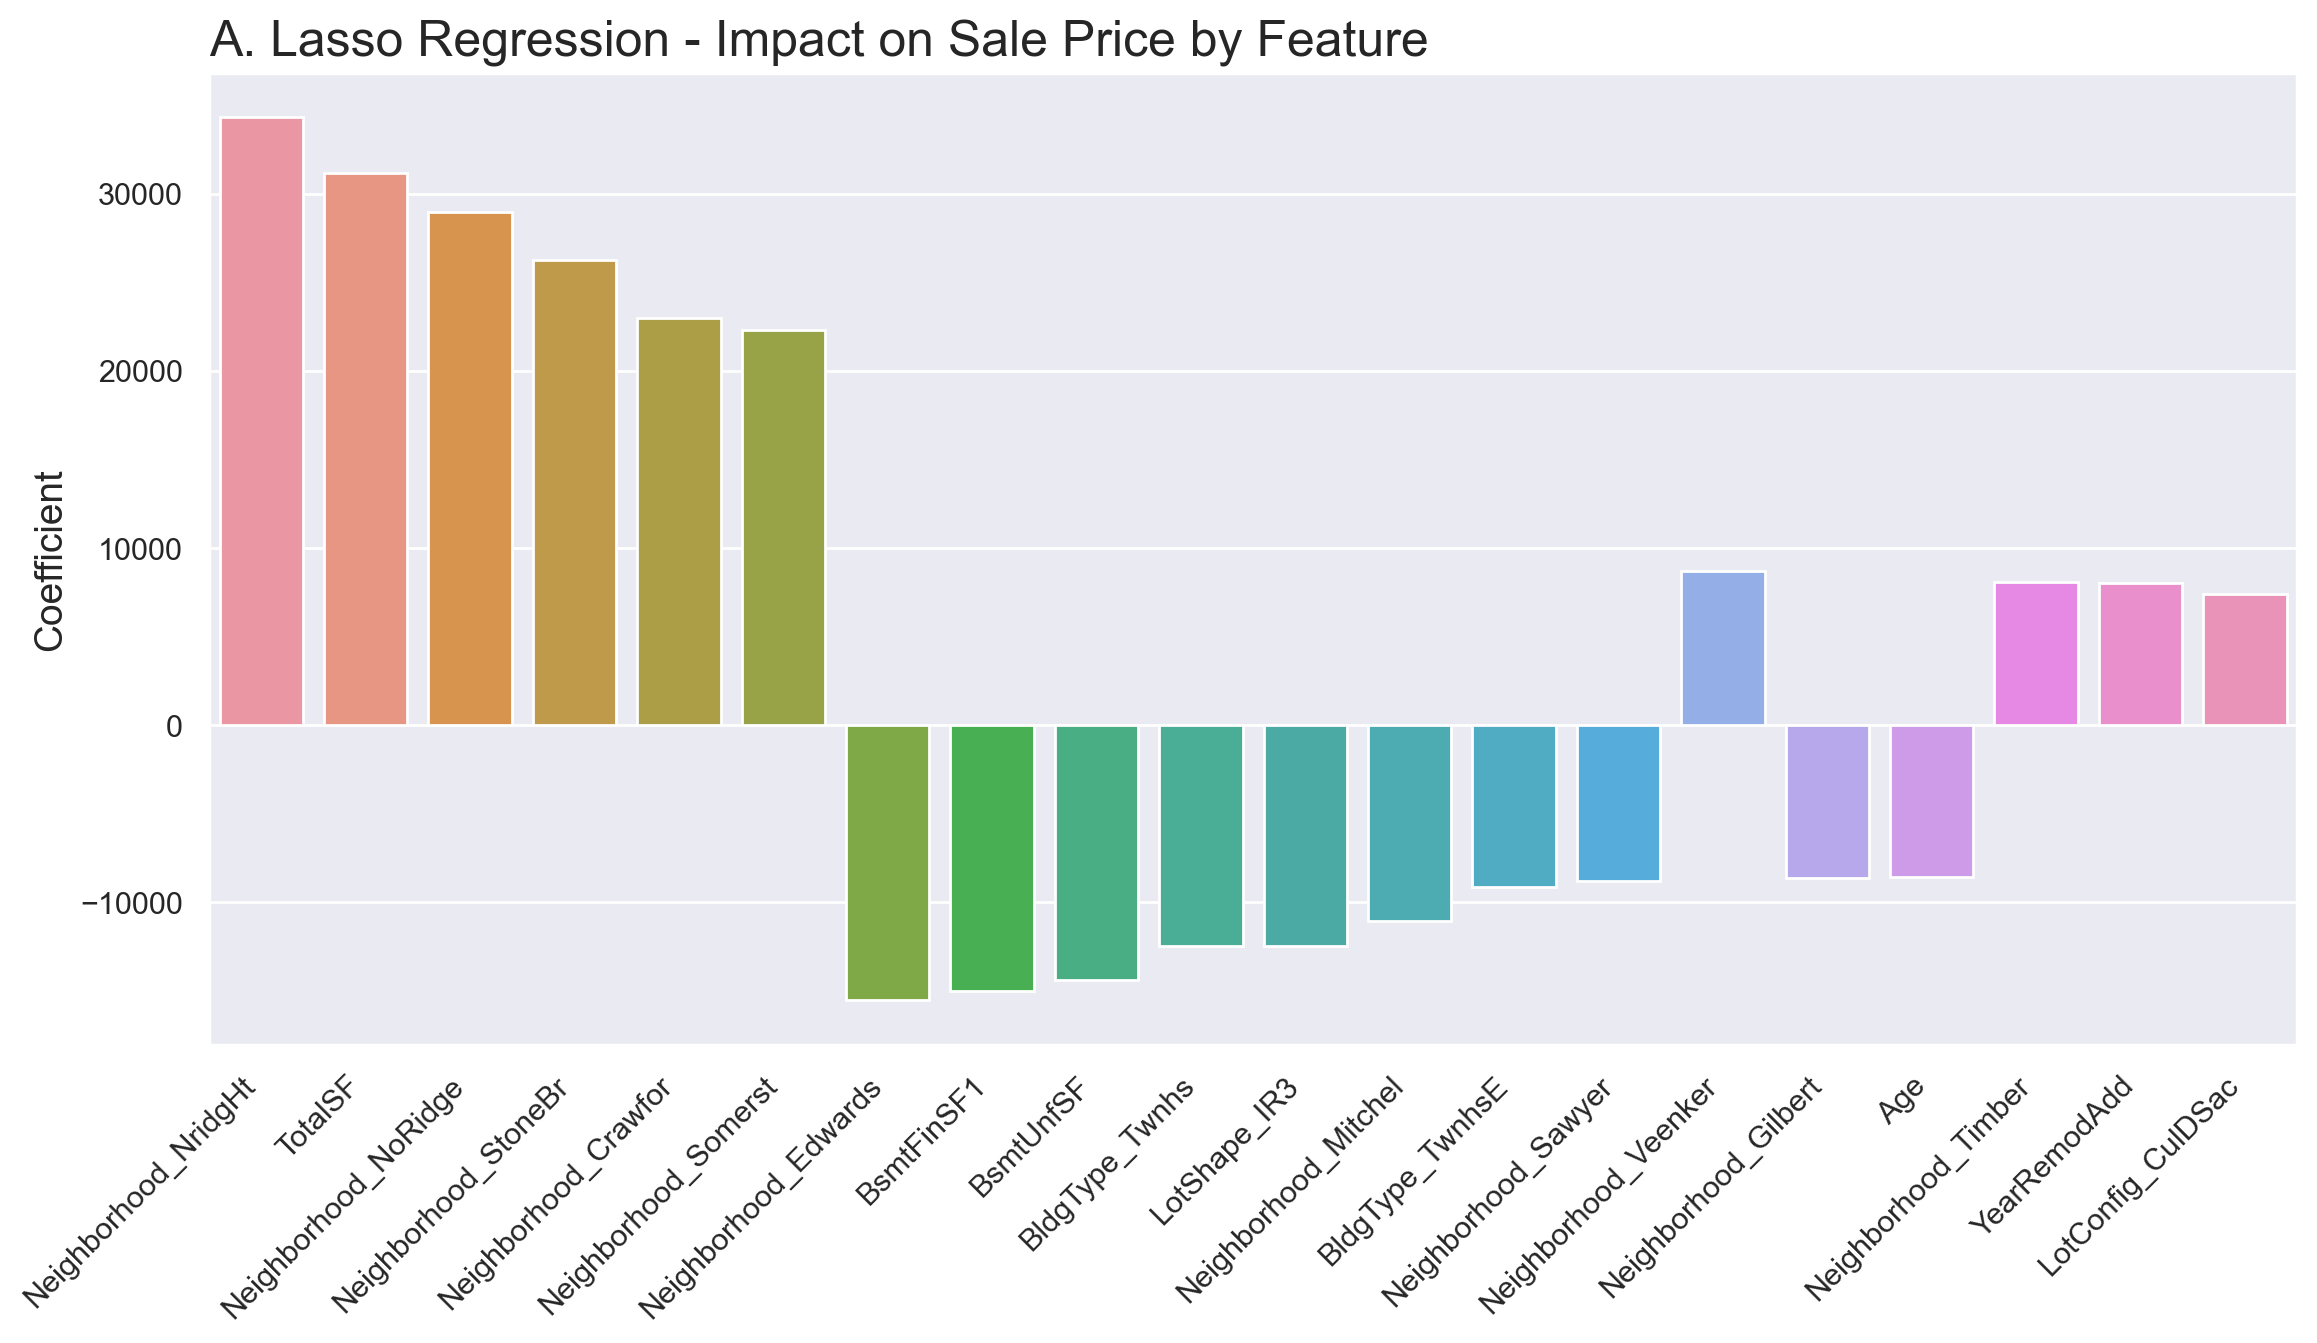

In [31]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=lasso_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('A. Lasso Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Ridge Regression with RidgeCV

In [22]:
# instantiate a RidgeCV model
opt_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_ridge.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_ridge.alpha_)

Optimal Alpha: 6.010276782070384


In [23]:
# instantiate the model
ridge = Ridge(alpha=opt_ridge.alpha_)

# fit the model
ridge.fit(X_train, y_train)

# calculate the scores
a_ridge_train = ridge.score(X_train, y_train)
a_ridge_test = ridge.score(X_test, y_test)
a_ridge_cv = (cross_val_score(ridge, X_train, y_train, cv = 10)).mean()

a_ridge_predictions_train = ridge.predict(X_train)
a_ridge_predictions = ridge.predict(X_test)

a_ridge_MSE = metrics.mean_squared_error(y_test, a_ridge_predictions)
a_ridge_MAE = metrics.mean_absolute_error(y_test, a_ridge_predictions)

# collect the scores in a dataframe to compare different models later
a_ridge_df = pd.DataFrame([a_ridge_train, a_ridge_test, a_ridge_cv, a_ridge_MSE, a_ridge_MAE],
                           index = ['train', 'test', 'CV', 'MSE', 'MAE'], columns=['A. Ridge Reg'])

# score the model
print('A. Ridge Regression Scores: \n')
print('R-squared train score: ', a_ridge_train)
print('R-squared test score:  ', a_ridge_test)
print('R-squared CV score:    ', a_ridge_cv)
print('Mean Squared Error:    ', a_ridge_MSE)
print('Mean Absolute Error:   ', a_ridge_MAE)

A. Ridge Regression Scores: 

R-squared train score:  0.8442446958531132
R-squared test score:   0.8593675768674891
R-squared CV score:     0.7638371054918791
Mean Squared Error:     488322513.9837405
Mean Absolute Error:    16212.672699669698


In [24]:
# display the model intercept
print('Intercept:', ridge.intercept_)

Intercept: 153294.36744279563


In [25]:
# collect the model coefficients in a dataframe
ridge_coef = pd.DataFrame(list(zip(X_train.columns, ridge.coef_)), columns = ['variable','coefficient'])
ridge_coef['coef_abs'] = abs(ridge_coef['coefficient'])

# display the largest model coefficients
ridge_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

,variable,coefficient,coef_abs
20,TotalSF,32552.979720,32552.979720
52,Neighborhood_NridgHt,28408.490751,28408.490751
51,Neighborhood_NoRidge,22824.064630,22824.064630
58,Neighborhood_StoneBr,21893.590528,21893.590528
43,Neighborhood_Edwards,-20856.406307,20856.406307
42,Neighborhood_Crawfor,18512.060985,18512.060985
62,Condition1_Norm,18203.204001,18203.204001
47,Neighborhood_Mitchel,-17413.080236,17413.080236
5,BsmtFinSF1,-16713.988190,16713.988190
7,BsmtUnfSF,-16600.217283,16600.217283


In [36]:
# display the coefficients which has been reduced to 0
ridge_zeroed = ridge_coef[ridge_coef['coefficient'] == 0].shape[0]
print('Ridge Regression has zeroed',ridge_zeroed , 'coefficients.')
list(ridge_coef['variable'][ridge_coef['coefficient'] == 0].values)

Ridge Regression has zeroed 0 coefficients.


[]

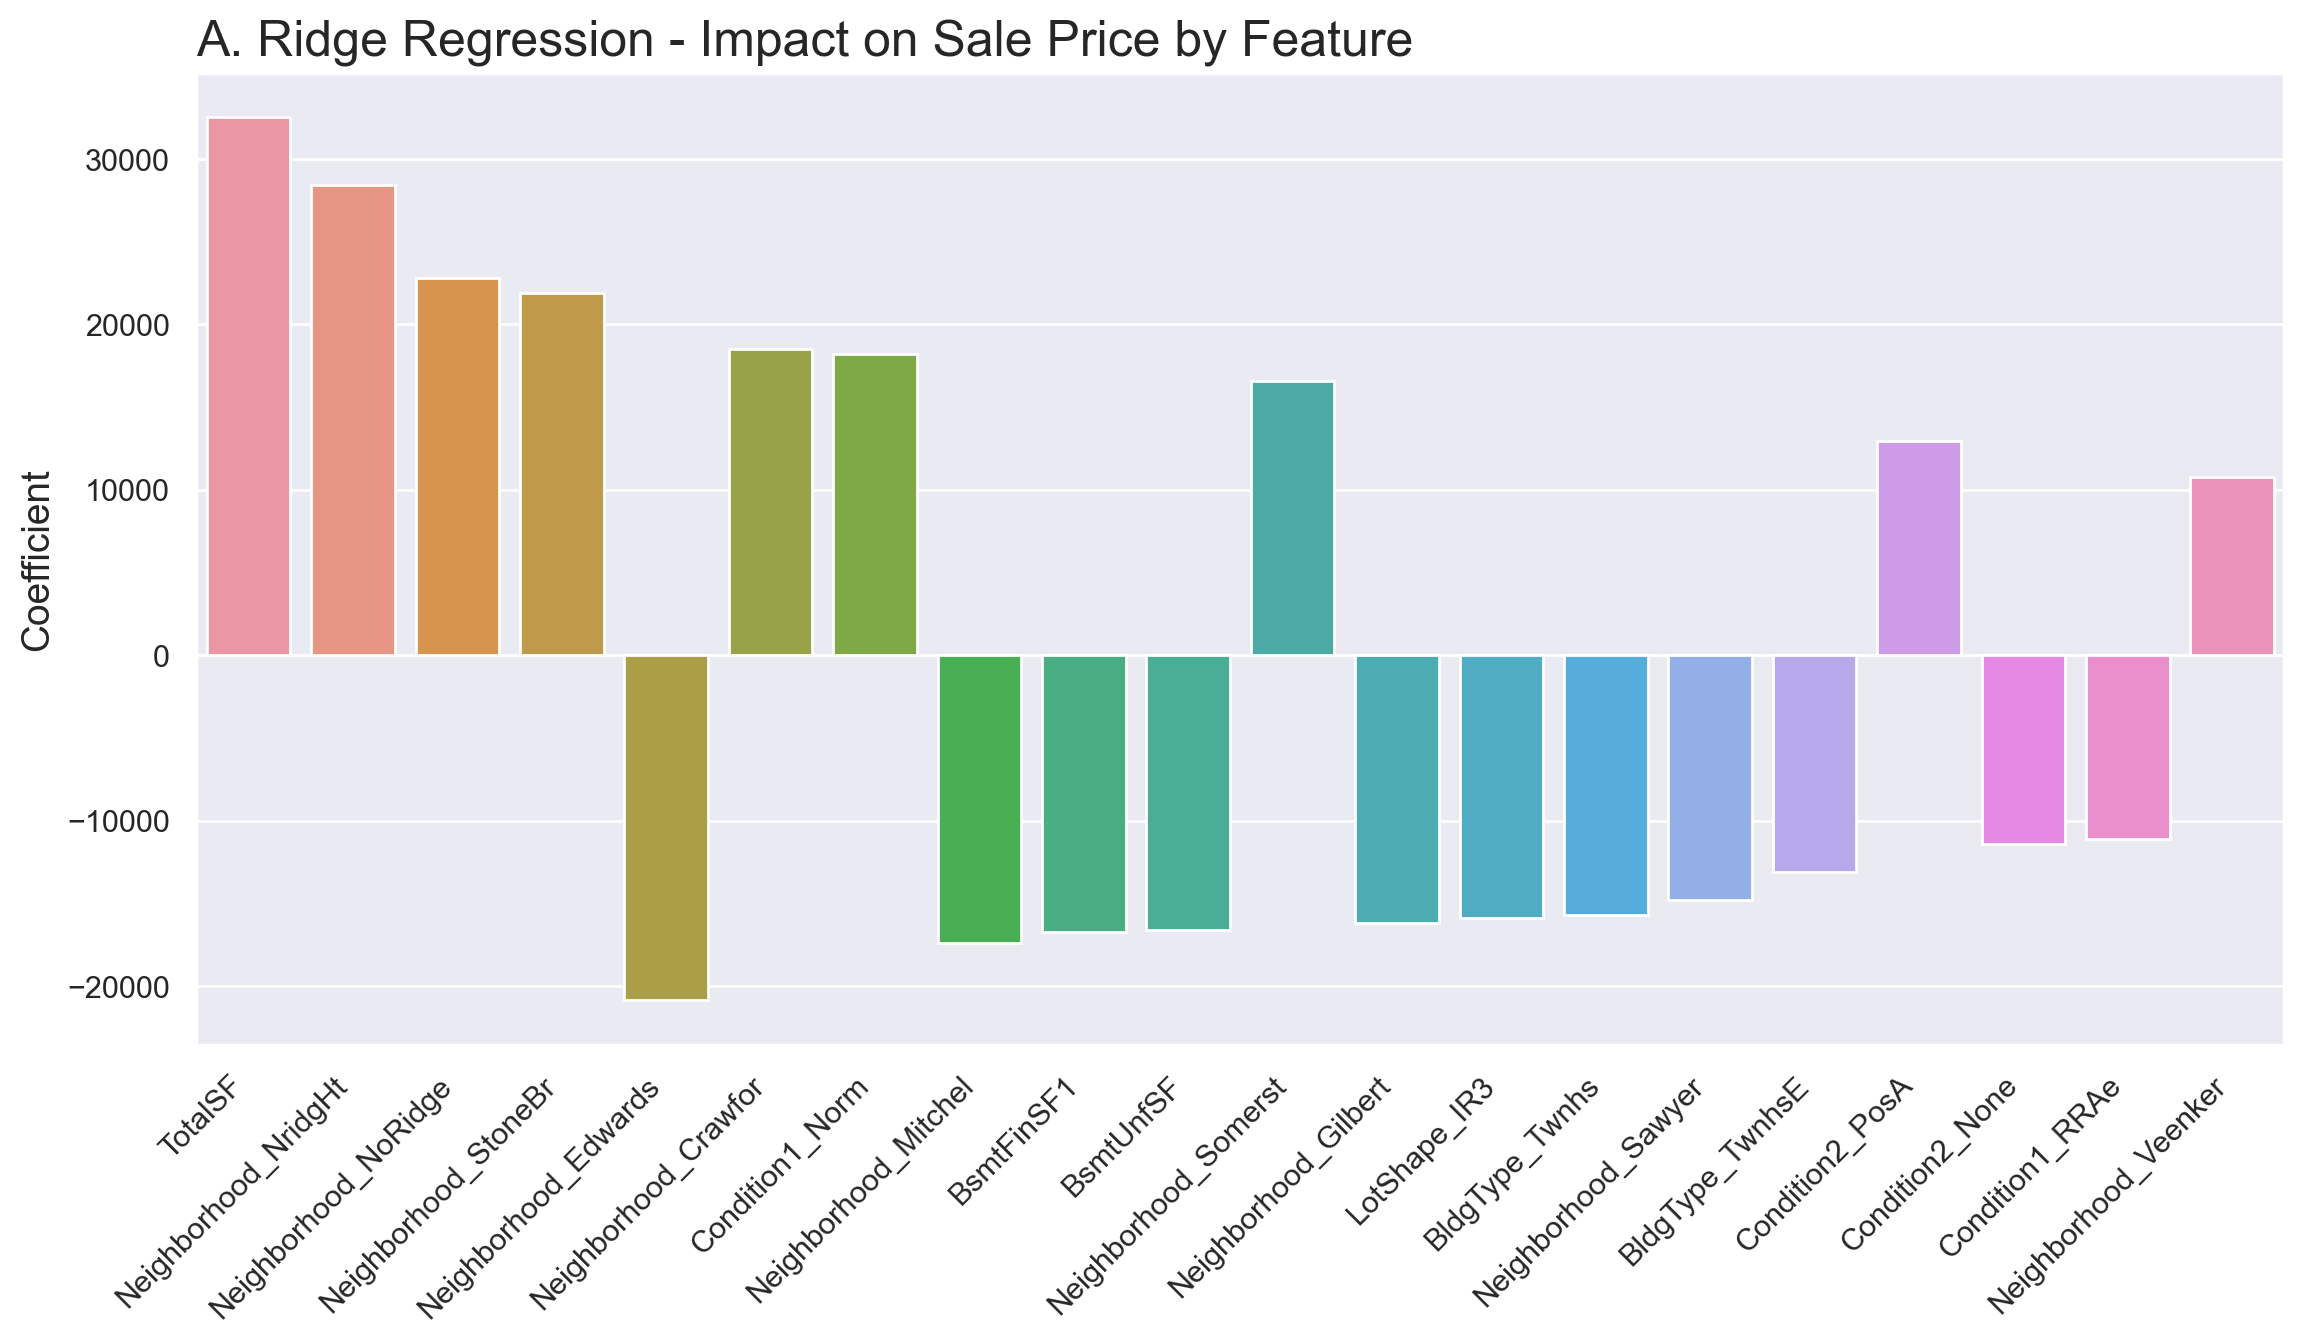

In [26]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=ridge_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('A. Ridge Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Elastic Net Regression with ElasticNetCV

In [38]:
# instantiate a ElasticnetCV model
opt_enet = ElasticNetCV(alphas=np.logspace(-4, 4, 10), l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                        max_iter = 100000, cv=10)

# fit the model
opt_enet.fit(X_train, y_train)

# display the optimal alpha and L1 ratio
print('Optimal Alpha:', opt_enet.alpha_)
print('Optimal L1 ratio:', opt_enet.l1_ratio_)

Optimal Alpha: 0.005994842503189409
Optimal L1 ratio: 0.1


In [39]:
# instantiate the model
enet = ElasticNet(alpha=opt_enet.alpha_, l1_ratio=opt_enet.l1_ratio_)

# fit the model
enet.fit(X_train, y_train)

# calculate the scores
a_enet_train = enet.score(X_train, y_train)
a_enet_test = enet.score(X_test, y_test)
a_enet_cv = (cross_val_score(enet, X_train, y_train, cv = 10)).mean()

a_enet_predictions_train = enet.predict(X_train)
a_enet_predictions = enet.predict(X_test)

a_enet_MSE = metrics.mean_squared_error(y_test, a_enet_predictions)
a_enet_MAE = metrics.mean_absolute_error(y_test, a_enet_predictions)

# collect the scores in a dataframe to compare different models later
a_enet_df = pd.DataFrame([a_enet_train, a_enet_test, a_enet_cv, a_enet_MSE, a_enet_MAE],
                           index = ['train', 'test', 'CV', 'MSE', 'MAE'], columns=['A. El-net Reg'])

# score the model
print('A. Elastic Net Regression Scores: \n')
print('R-squared train score: ', a_enet_train)
print('R-squared test score:  ', a_enet_test)
print('R-squared CV score:    ', a_enet_cv)
print('Mean Squared Error:    ', a_enet_MSE)
print('Mean Absolute Error:   ', a_enet_MAE)

A. Elastic Net Regression Scores: 

R-squared train score:  0.8436432800090587
R-squared test score:   0.8593297320859637
R-squared CV score:     0.7638370360151739
Mean Squared Error:     488453923.64336234
Mean Absolute Error:    16208.044198161013


In [40]:
# display the model intercept
print('Intercept:', enet.intercept_)

Intercept: 153709.5953555629


In [41]:
# collect the model coefficients in a dataframe
enet_coef = pd.DataFrame(list(zip(X_train.columns, enet.coef_)), columns = ['variable','coefficient'])
enet_coef['coef_abs'] = abs(enet_coef['coefficient'])

# display the largest model coefficients
enet_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

,variable,coefficient,coef_abs
20,TotalSF,32293.265637,32293.265637
52,Neighborhood_NridgHt,27927.009992,27927.009992
51,Neighborhood_NoRidge,22449.768140,22449.768140
58,Neighborhood_StoneBr,21201.835670,21201.835670
43,Neighborhood_Edwards,-20582.146987,20582.146987
42,Neighborhood_Crawfor,18425.784767,18425.784767
62,Condition1_Norm,17212.175610,17212.175610
47,Neighborhood_Mitchel,-17114.620355,17114.620355
5,BsmtFinSF1,-16444.453373,16444.453373
57,Neighborhood_Somerst,16329.409232,16329.409232


In [42]:
# display the coefficients which has been reduced to 0
enet_zeroed = enet_coef[enet_coef['coefficient'] == 0].shape[0]
print('Elastic Net Regression has zeroed',enet_zeroed , 'coefficients.')
list(enet_coef['variable'][enet_coef['coefficient'] == 0].values)

Elastic Net Regression has zeroed 0 coefficients.


[]

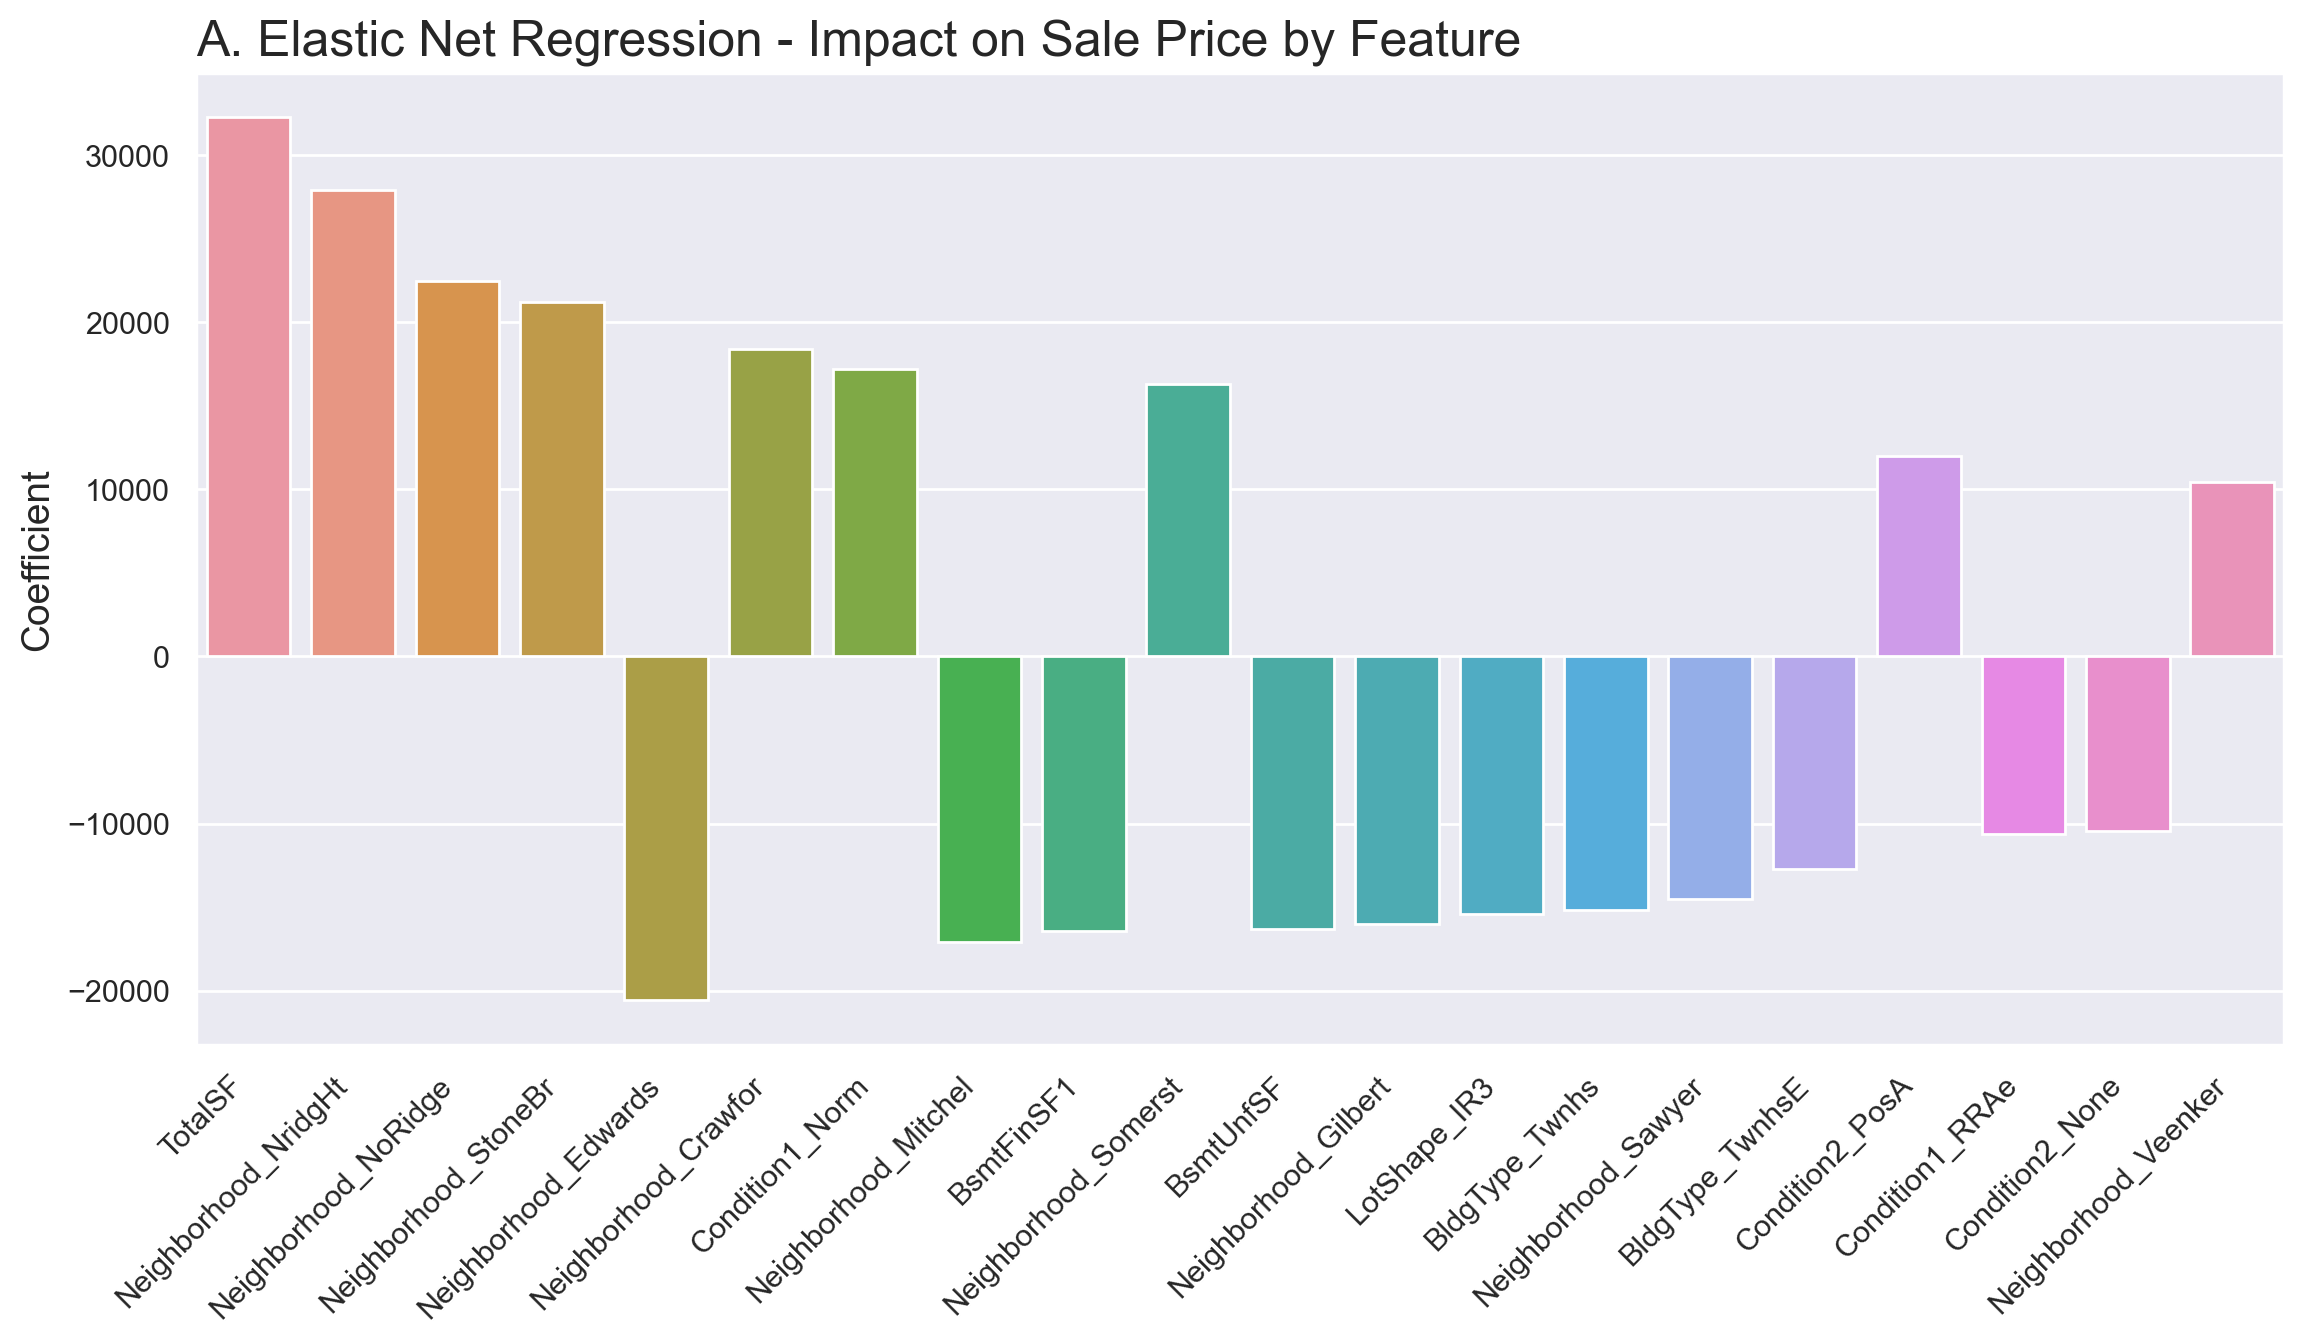

In [43]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=enet_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('A. Elastic Net Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Model Set Score Evaluation

In [51]:
A_models = pd.concat([a_linreg_df, a_lasso_df, a_ridge_df, a_enet_df], axis = 1)
A_models.round(decimals=5)

,A. Linear Reg,A. Lasso Reg,A. Ridge Reg,A. El-net Reg
train,8.539600e-01,8.352900e-01,8.442400e-01,8.436400e-01
test,-7.383840e+23,8.598200e-01,8.593700e-01,8.593300e-01
CV,-1.176401e+19,7.637900e-01,7.638400e-01,7.638400e-01
MSE,2.563915e+33,4.867409e+08,4.883225e+08,4.884539e+08
MAE,3.941938e+15,1.622047e+04,1.621267e+04,1.620804e+04


Among the four models implemented above, **Lasso Regression** achieved the highest test score of **0.8598**  

<br/><br/>

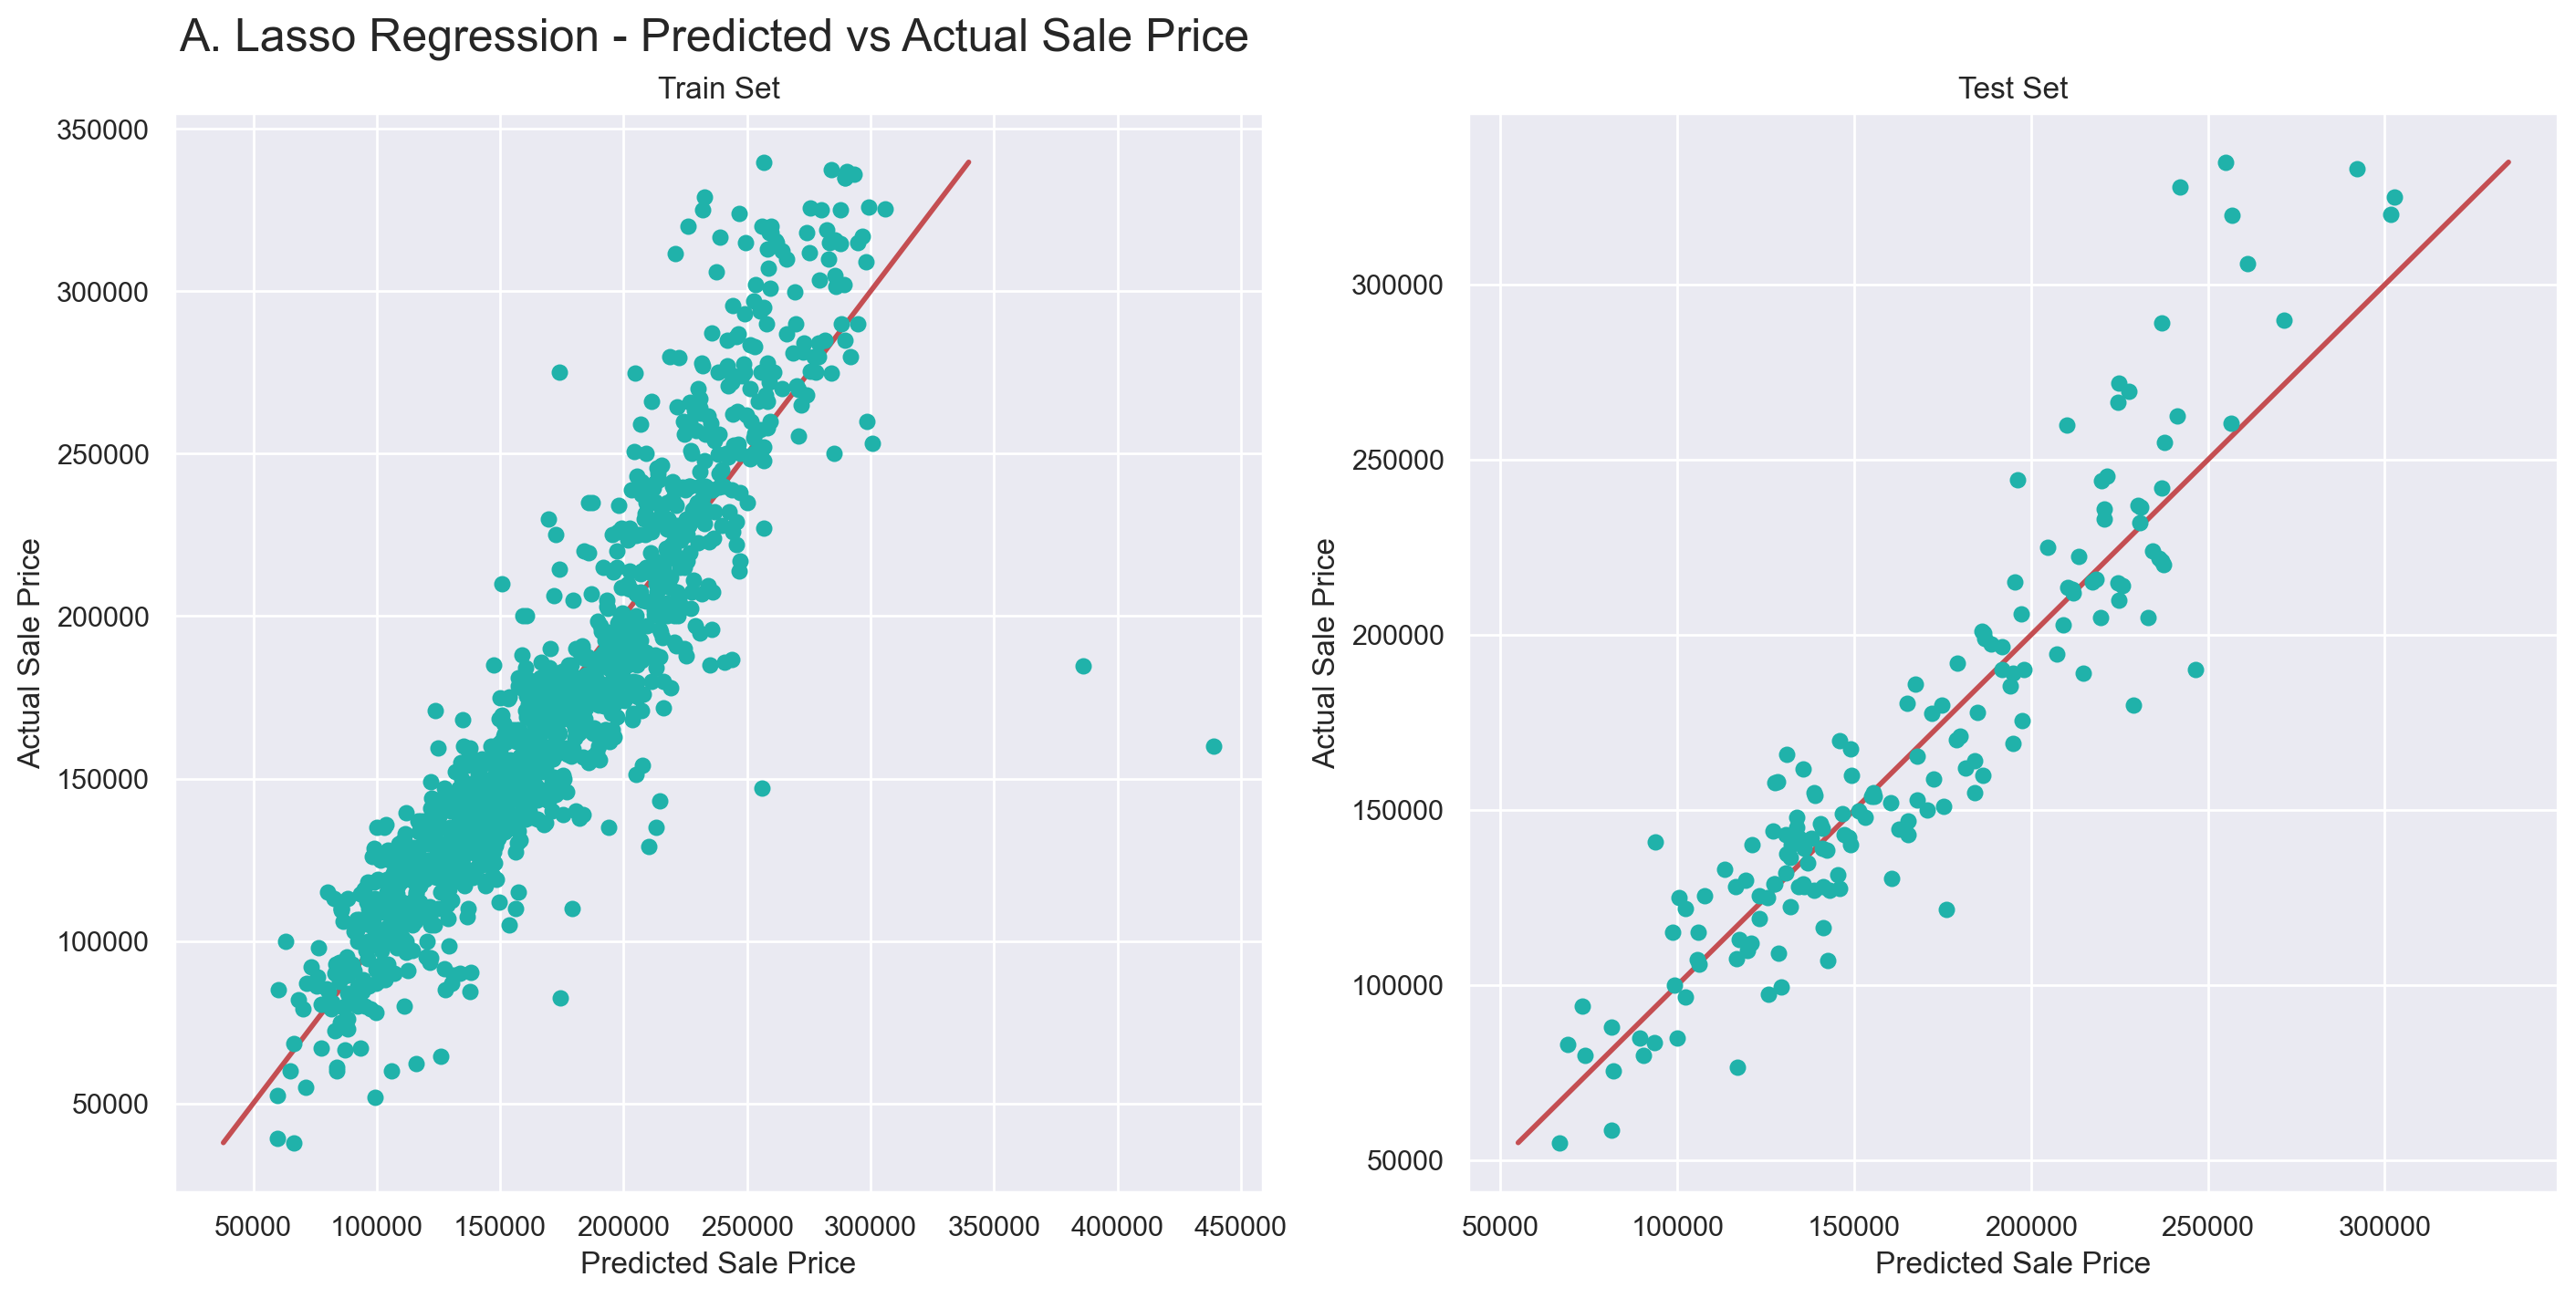

In [70]:
# plot the predicted y values against the actual y values by the lasso method
fig, ax = plt.subplots(ncols=2, figsize=(14, 7), constrained_layout=True)

fig.suptitle('A. Lasso Regression - Predicted vs Actual Sale Price', x=0.485, horizontalalignment='right', fontsize=18)

ax[0].scatter(a_lasso_predictions_train, y_train, s=30, color = 'lightseagreen', zorder=10)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='r', lw=2)
ax[0].set_ylabel('Actual Sale Price')
ax[0].set_xlabel('Predicted Sale Price')
ax[0].set_title('Train Set')

ax[1].scatter(a_lasso_predictions, y_test, s=30, color='lightseagreen', zorder=10)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r', lw=2)
ax[1].set_ylabel('Actual Sale Price')
ax[1].set_xlabel('Predicted Sale Price')
ax[1].set_title('Test Set')

plt.show()

In [73]:
# calculate the residuals for the lasso method for the train dataset
df_train = pd.DataFrame({'y_train': y_train, 'y_hat' : a_lasso_predictions_train})
df_train['residuals'] = df_train['y_train'] - df_train['y_hat']

# calculate the residuals for the lasso method for the test dataset
df_test = pd.DataFrame({'y_test': y_test, 'y_hat' : a_lasso_predictions})
df_test['residuals'] = df_test['y_test'] - df_test['y_hat']
df_test

,y_test,y_hat,residuals
15,149000,146556.840678,2443.159322
23,154000,155713.821431,-1713.821431
25,134800,136848.834428,-2048.834428
26,306000,261121.829278,44878.170722
31,165500,167864.206099,-2364.206099
...,...,...,...
1357,149700,151339.217358,-1639.217358
1365,157900,127440.856079,30459.143921
1375,210000,224820.619618,-14820.619618
1376,266500,224484.431761,42015.568239


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
"""

I am going to use the changeable features in the predictor matrix and fit a new model.


"""

In [ ]:
# copy the updated dataframe to create a new predictor matrix

df2 = df.copy().reset_index()
df2

In [ ]:
df2.drop(columns=['level_0', 'index'], inplace=True)
df2

In [ ]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: